# Libraries import

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"
# %cd /content/gdrive/My Drive/Colab Notebooks

In [2]:
# # uncomment this cell for first run to install the packages.
# !pip install quandl
# !pip install ta 
# !pip install git+https://github.com/ourownstory/neural_prophet.git
# !pip install -U prophet
# !pip install  -U statsmodels
# !pip install -U sklearn
# !pip install -U scikit-learn
# !pip install -U pmdarima

In [3]:
# import os
import numpy as np
import pandas as pd
import re
from math import sqrt
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
# for mean_squared_error set squared = False for RMSE, (y_true, y_pred)
from sklearn.model_selection import train_test_split

# stats models
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
import statsmodels.graphics.tsaplots as sgt

from pmdarima import auto_arima
from fbprophet import Prophet
import copy
import random
import sys
import itertools
import warnings
import os
from prophet.plot import add_changepoints_to_plot
warnings.filterwarnings('ignore')

In [4]:
path = './Outputs/'
if(not os.path.isdir(path)):
    os.mkdir(path)

pathProphet = path+'ProphetSingle/'
if(not os.path.isdir(pathProphet)):
    os.mkdir(pathProphet)
    
pathProphetMultiple = path+'ProphetMultiple/'
if(not os.path.isdir(pathProphetMultiple)):
    os.mkdir(pathProphetMultiple)

pathNeuralProphet = path+'NeuralProphetSingle/'
if(not os.path.isdir(pathNeuralProphet)):
    os.mkdir(pathNeuralProphet)
    
pathNeuralProphetMultiple = path+'NeuralProphetSingleMultiple/'
if(not os.path.isdir(pathNeuralProphetMultiple)):
    os.mkdir(pathNeuralProphetMultiple)
    
# pathProphet, pathProphetMultiple, pathNeuralProphet, pathNeuralProphetMultiple

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
quandl.ApiConfig.api_key = "key here# 6b7jcHuxwW7Wot1kyFNS

# Data to be used

In [7]:
metadata = pd.read_csv('BSE_metadata.csv')
metadata.head()

,code,name,description,refreshed_at,from_date,to_date
0,BOM500002,ABB India Limited EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
1,BOM500003,AEGIS LOGISTICS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
2,BOM500008,AMARA RAJA BATTERIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
3,BOM500009,AMBALAL SARABHAI ENTERPRISES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
4,BOM500010,HOUSING DEVELOPMENT FINANCE CORP.LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,1/3/1992,1/18/2021


## Utility variables and functions

In [8]:
### Codes of selected stocks
healthcare = ['BOM524715','BOM532488','BOM500124']
banking = ['BOM500180','BOM532174','BOM500247']
metals = ['BOM500470','BOM500228','BOM500440']
auto = ['BOM532977','BOM500570','BOM532500']
it = ['BOM500209','BOM532540','BOM507685']
BSE_HEALTHCARE = 'SI0800'
BSE_Information_Technology = 'SI1000'
BSE_BANKEX = 'SIBANK'
BSE_METAL = 'SI1200'
BSE_AUTO = 'SI1900'
SENSEX = 'SENSEX'

stocks = healthcare+banking+metals + auto+it
indices = [BSE_HEALTHCARE, BSE_Information_Technology, BSE_BANKEX, BSE_METAL, BSE_AUTO, SENSEX]
allSymbols = stocks + indices
ScriptWiseData = {}

In [9]:
# Global Variables
RSIColumn = 'RSI'
ATRColumns = ['TR', 'ATR']
MACDColumns = ['FastAverage', 'SlowAverage','MACD','Signal']
BollBandColumns = ['BB_up',"BB_dn","MA","BB_width"]
ADXColumns = ['pos_directional_indicator', 'neg_directional_indicator', 'adx']
OnBalanceVolume = 'OBV'
TechnicalIndicators = ['RSI', 'ATR', 'MACD', 'adx', 'OBV'] #exogenous variables

AllIndicatorColumns = [RSIColumn]+ATRColumns+MACDColumns+BollBandColumns+ADXColumns+[OnBalanceVolume]

In [10]:
start_date = '2020-03-02'
end_date = '2021-03-23'

In [11]:
# get null values of all the stocks
def getNullValuesForSetOfStocks(stockCodeList = stocks):
    nullCounts = pd.DataFrame(ScriptWiseData[stockCodeList[0]].isnull().sum(), columns= [getStockNameFromStockCode(stockCodeList[0])])
    for symbol in stockCodeList[1:]:
        currNull = pd.DataFrame(ScriptWiseData[symbol].isnull().sum(), columns= [getStockNameFromStockCode(symbol)])
        nullCounts = nullCounts.merge(currNull, left_index=True, right_index = True, how='outer')
    return nullCounts

In [12]:
def adf_test(series, title = ''):
    """
    Pass in a time series and an optional title
    """
    result = sts.adfuller(series.dropna(), autolag = 'AIC')
    label = ['ADF test statistic', 'p-value', '# lags used', '#observations']
#     print(result)
    out = pd.Series(result[0:4], index=label)
    out['Stock Name'] = getStockNameFromStockCode(title)
    out['Stock Code'] = title
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
#     print(out)
    if(result[1]<0.05):
        return out, 'Stationary'
    else:
        return out, 'Non-Stationary'

In [13]:
stockMetadata = metadata[metadata['code'].isin(allSymbols)]
stockMetadata.head()

,code,name,description,refreshed_at,from_date,to_date
70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021
121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021


In [14]:
print(stockMetadata.shape)
print(stockMetadata[stockMetadata['code'].isin(stocks)].shape)
print(stockMetadata[stockMetadata['code'].isin(indices)].shape)

(21, 6)
(15, 6)
(6, 6)


## Map Index to  stocks

In [15]:
stockMetadata.loc[:, 'isStock'] = 0
stockMetadata.loc[:, 'Index'] = ''

stockMetadata.loc[stockMetadata['code'].isin(stocks), 'isStock'] = 1
stockMetadata.reset_index(inplace=True)

In [16]:
stockMetadata.loc[stockMetadata['code'].isin(healthcare), 'Index'] = BSE_HEALTHCARE
stockMetadata.loc[stockMetadata['code'].isin(banking), 'Index'] = BSE_BANKEX
stockMetadata.loc[stockMetadata['code'].isin(metals), 'Index'] = BSE_METAL
stockMetadata.loc[stockMetadata['code'].isin(auto), 'Index'] = BSE_AUTO
stockMetadata.loc[stockMetadata['code'].isin(it), 'Index'] = BSE_Information_Technology

In [17]:
stockMetadata.head()

,index,code,name,description,refreshed_at,from_date,to_date,isStock,Index
0,70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021,1,SI0800
1,104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021,1,SIBANK
2,121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1000
3,133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1200
4,146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SIBANK


In [18]:
stockMetadata['isStock'].value_counts()

1    15
0     6
Name: isStock, dtype: int64

# Code to download the data from quandl. 

In [19]:
# # download the required data - needed only 1 time
# i=0
# code = f'BSE/{stockMetadata.loc[i, "code"]}'
# dataset = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
# dataset['StockName']=stockMetadata.loc[i, 'name']
# dataset['code'] = stockMetadata.loc[i, "code"]
# dataset['isStock'] = stockMetadata.loc[i, "isStock"]
# dataset['Index'] = stockMetadata.loc[i, "Index"]
# for i in range(1, len(stockMetadata)):
#     code = f'BSE/{stockMetadata.loc[i, "code"]}'
#     temp = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
#     temp['StockName']=stockMetadata.loc[i, 'name']
#     temp['code'] = stockMetadata.loc[i, "code"]
#     temp['isStock'] = stockMetadata.loc[i, "isStock"]
#     temp['Index'] = stockMetadata.loc[i, "Index"]
# #     print( stockMetadata.loc[i, "Index"])
#     dataset = dataset.append(temp)
# dataset.to_csv('data.csv')
# dataset.head()

In [20]:
dataset = pd.read_csv('data.csv')
dataset.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
0,2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
1,2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2,2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
3,2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
4,2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105449 entries, 0 to 105448
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       105449 non-null  object 
 1   Open                       95130 non-null   float64
 2   High                       95130 non-null   float64
 3   Low                        95130 non-null   float64
 4   Close                      105449 non-null  float64
 5   WAP                        74255 non-null   float64
 6   No. of Shares              74255 non-null   float64
 7   No. of Trades              74255 non-null   float64
 8   Total Turnover             74255 non-null   float64
 9   Deliverable Quantity       68110 non-null   float64
 10  % Deli. Qty to Traded Qty  68110 non-null   float64
 11  Spread H-L                 74255 non-null   float64
 12  Spread C-O                 74255 non-null   float64
 13  StockName                  10

### Verify the min and max of dates of all selected stocks and indices

In [22]:
dateRanges = dataset.groupby(['code', 'StockName']).agg({'Date': ['min', 'max']}).reset_index()
dateRanges.columns = ['Stock Code', 'Stock Name', 'First Date', 'Last Date']
dateRanges

,Stock Code,Stock Name,First Date,Last Date
0,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,2000-01-03,2021-03-23
1,BOM500180,HDFC Bank Ltd EOD Prices,2000-01-03,2021-03-23
2,BOM500209,INFOSYS LTD. EOD Prices,2000-01-03,2021-03-23
3,BOM500228,JSW STEEL LTD. EOD Prices,2000-01-03,2021-03-23
4,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,2000-01-03,2021-03-23
5,BOM500440,HINDALCO INDUSTRIES LTD. EOD Prices,2000-01-03,2021-03-23
6,BOM500470,TATA STEEL LTD. EOD Prices,2000-01-03,2021-03-23
7,BOM500570,TATA MOTORS LTD. EOD Prices,2000-01-03,2021-03-23
8,BOM507685,WIPRO LTD. EOD Prices,2000-01-03,2021-03-23
9,BOM524715,SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,2000-01-03,2021-03-23


In [23]:
# use above ranges to get stockName
def getStockNameFromStockCode(stockCode):
    return dateRanges.loc[dateRanges['Stock Code']==stockCode, 'Stock Name'].values[0].replace('EOD Prices', '');

In [24]:
data = dataset.set_index('Date')
data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
Date,,,,,,,,,,,,,,,,
2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


### Populate dictionary to hold individual Stock Data

In [25]:
# ScriptWiseData = {'Symbol1': <DatqaFrame>, 'Suymbol 2':Dataframe2}
for symbol in allSymbols:
    ScriptWiseData[symbol] = data.loc[data.code==symbol]

### View null values in the data 

In [26]:
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD.,DIVI'S LABORATORIES LTD.,DR.REDDY'S LABORATORIES LTD.,HDFC Bank Ltd,ICICI BANK LTD.,KOTAK MAHINDRA BANK LTD.,TATA STEEL LTD.,JSW STEEL LTD.,HINDALCO INDUSTRIES LTD.,BAJAJ AUTO LTD.,TATA MOTORS LTD.,MARUTI SUZUKI INDIA LTD.,INFOSYS LTD.,TATA CONSULTANCY SERVICES LTD.,WIPRO LTD.
Open,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WAP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
No. of Shares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
No. of Trades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Total Turnover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Deliverable Quantity,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538
% Deli. Qty to Traded Qty,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538


# Deriving Technical indicators 

### MACD

In [27]:
# function to create data MACD signal and data. 
def MACD(df, span1 = 12, span2= 26, span3 = 9):
    stockData = df.copy()
    stockData['FastAverage'] = stockData['Close'].ewm(span = span1, min_periods = span1).mean()
    stockData['SlowAverage'] = stockData['Close'].ewm(span = span2, min_periods = span2).mean()
    stockData['MACD'] = stockData['FastAverage'] - stockData['SlowAverage']
    stockData['Signal'] = stockData['MACD'].ewm(span=span3, min_periods = span3).mean()
    return stockData[MACDColumns]

In [28]:
# create stock code based dataframes with MACD signal
for symbol in allSymbols:
    macd = MACD(ScriptWiseData[symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(macd, left_index=True, right_index = True, how='left')

### RSI - Relative Strength Index

In [29]:
# Calculating RSI without using loop
def RSI(DF, n=14):
    df =  DF.copy()
    "function to calculate RSI"
    delta = df['Close'].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    rsi = 100 - 100 / (1+rs);
    return pd.DataFrame(rs).rename(columns={'Close':'RSI'})

In [30]:
#RSI 
for symbol in allSymbols:   
    rsi = RSI(data.loc[data.code==symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(rsi, left_index=True, right_index = True, how='left')

### ATR

In [31]:
def ATR(DF,n=20):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2[ATRColumns]

In [32]:
#ATR 
for symbol in allSymbols:
    ScriptWiseData[symbol][ATRColumns] = ATR(data.loc[data.code==symbol])

### Bollinger band

In [33]:
def BollBnd(DF,n=14):
    "function to calculate Bollinger Band"
    df = DF.copy()
    df["MA"] = df['Close'].rolling(n).mean()
    df["BB_up"] = df["MA"] + 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_dn"] = df["MA"] - 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_width"] = df["BB_up"] - df["BB_dn"]
#     df.dropna(inplace=True)
    return df[BollBandColumns]

In [34]:
#Boll band
for symbol in allSymbols:
    ScriptWiseData[symbol][BollBandColumns] = BollBnd(data.loc[data.code==symbol])

### OBV

In [35]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['No. of Shares'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [36]:
#OBV
for symbol in allSymbols:
    ScriptWiseData[symbol]['OBV'] = OBV(data.loc[data.code==symbol])

### ADX

In [37]:
from ta.trend import ADXIndicator
def ADX(DF):
    df = DF.copy()
    adxI = ADXIndicator(df['High'],df['Low'],df['Close'],14,False)
    df['pos_directional_indicator'] = adxI.adx_pos()
    df['neg_directional_indicator'] = adxI.adx_neg()
    df['adx'] = adxI.adx()
    return df[ADXColumns]

In [38]:
# ADX
for symbol in allSymbols:
    ScriptWiseData[symbol][ADXColumns] = ADX(data.loc[data.code==symbol])

In [39]:
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD.,DIVI'S LABORATORIES LTD.,DR.REDDY'S LABORATORIES LTD.,HDFC Bank Ltd,ICICI BANK LTD.,KOTAK MAHINDRA BANK LTD.,TATA STEEL LTD.,JSW STEEL LTD.,HINDALCO INDUSTRIES LTD.,BAJAJ AUTO LTD.,TATA MOTORS LTD.,MARUTI SUZUKI INDIA LTD.,INFOSYS LTD.,TATA CONSULTANCY SERVICES LTD.,WIPRO LTD.
Open,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WAP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
No. of Shares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
No. of Trades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Total Turnover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Deliverable Quantity,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538
% Deli. Qty to Traded Qty,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538


# Removing Extra Columms

In [40]:
OriginalScriptWiseData = ScriptWiseData
for symbol in allSymbols:
    ScriptWiseData[symbol] = ScriptWiseData[symbol][['Close']+TechnicalIndicators]

## Dropping null values

In [41]:
# drop rows from the stock whose technical indicator values are null. 
for stock in stocks:
#     ScriptWiseData[stock] = ScriptWiseData[stock].dropna(subset=AllIndicatorColumns)
    ScriptWiseData[stock] = ScriptWiseData[stock].dropna()    

In [42]:
# ScriptWiseData['BOM500180'][ScriptWiseData['BOM500180']['MACD'].isna()]
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD.,DIVI'S LABORATORIES LTD.,DR.REDDY'S LABORATORIES LTD.,HDFC Bank Ltd,ICICI BANK LTD.,KOTAK MAHINDRA BANK LTD.,TATA STEEL LTD.,JSW STEEL LTD.,HINDALCO INDUSTRIES LTD.,BAJAJ AUTO LTD.,TATA MOTORS LTD.,MARUTI SUZUKI INDIA LTD.,INFOSYS LTD.,TATA CONSULTANCY SERVICES LTD.,WIPRO LTD.
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RSI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ATR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MACD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
adx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OBV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
finalDateRanges =pd.DataFrame(columns = ['Stock Code', 'Stock Name', 'First Date', 'Last Date']) 
for s in stocks:
    r = [s, getStockNameFromStockCode(s), ScriptWiseData[s].index.min(),  ScriptWiseData[s].index.max()]
    finalDateRanges.loc[len(finalDateRanges)] = r
finalDateRanges

,Stock Code,Stock Name,First Date,Last Date
0,BOM524715,SUN PHARMACEUTICAL INDUSTRIES LTD.,2000-02-10,2021-03-23
1,BOM532488,DIVI'S LABORATORIES LTD.,2003-04-23,2021-03-23
2,BOM500124,DR.REDDY'S LABORATORIES LTD.,2000-02-10,2021-03-23
3,BOM500180,HDFC Bank Ltd,2000-02-10,2021-03-23
4,BOM532174,ICICI BANK LTD.,2000-02-10,2021-03-23
5,BOM500247,KOTAK MAHINDRA BANK LTD.,2000-02-10,2021-03-23
6,BOM500470,TATA STEEL LTD.,2000-02-10,2021-03-23
7,BOM500228,JSW STEEL LTD.,2000-02-10,2021-03-23
8,BOM500440,HINDALCO INDUSTRIES LTD.,2000-02-10,2021-03-23
9,BOM532977,BAJAJ AUTO LTD.,2008-07-02,2021-03-23


# ADF Test for closing price

In [44]:
stock = stocks[0]
adf_testResult = pd.DataFrame(adf_test(ScriptWiseData[stocks[0]].Close, stocks[0])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
for i in range(1, len(stocks)):
    res = pd.DataFrame(adf_test(ScriptWiseData[stocks[i]].Close, stocks[i])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
    adf_testResult = adf_testResult.append(res)
adf_testResult['Result'] = adf_testResult['p-value'].apply(lambda x: 'Stationary' if x<0.05 else 'Non-Stationary')
# adf_testResult.to_csv('Outputs/adfTest.csv')
adf_testResult.head()

,,ADF test statistic,p-value,# lags used,#observations,critical value (1%),critical value (5%),critical value (10%),Result
Stock Name,Stock Code,,,,,,,,
SUN PHARMACEUTICAL INDUSTRIES LTD.,BOM524715,-5.025755,0.00002,0.0,5253.0,-3.431595,-2.86209,-2.567063,Stationary
DIVI'S LABORATORIES LTD.,BOM532488,-3.571373,0.006333,32.0,4424.0,-3.431829,-2.862194,-2.567118,Stationary
DR.REDDY'S LABORATORIES LTD.,BOM500124,-0.081726,0.951229,28.0,5226.0,-3.431602,-2.862093,-2.567064,Non-Stationary
HDFC Bank Ltd,BOM500180,-2.223959,0.197665,0.0,5254.0,-3.431595,-2.86209,-2.567063,Non-Stationary
ICICI BANK LTD.,BOM532174,-2.658944,0.081416,1.0,5252.0,-3.431596,-2.86209,-2.567063,Non-Stationary


# Train test and validation split

In [45]:
def TrainTestSplitByDateRange(df,test_start_date = '2020-03-02',test_end_date = '2021-03-23'):
    train = df.iloc[:df.index.get_loc(test_start_date)]
    test = df.loc[test_start_date:test_end_date]
    return train, test

### Plot PACF

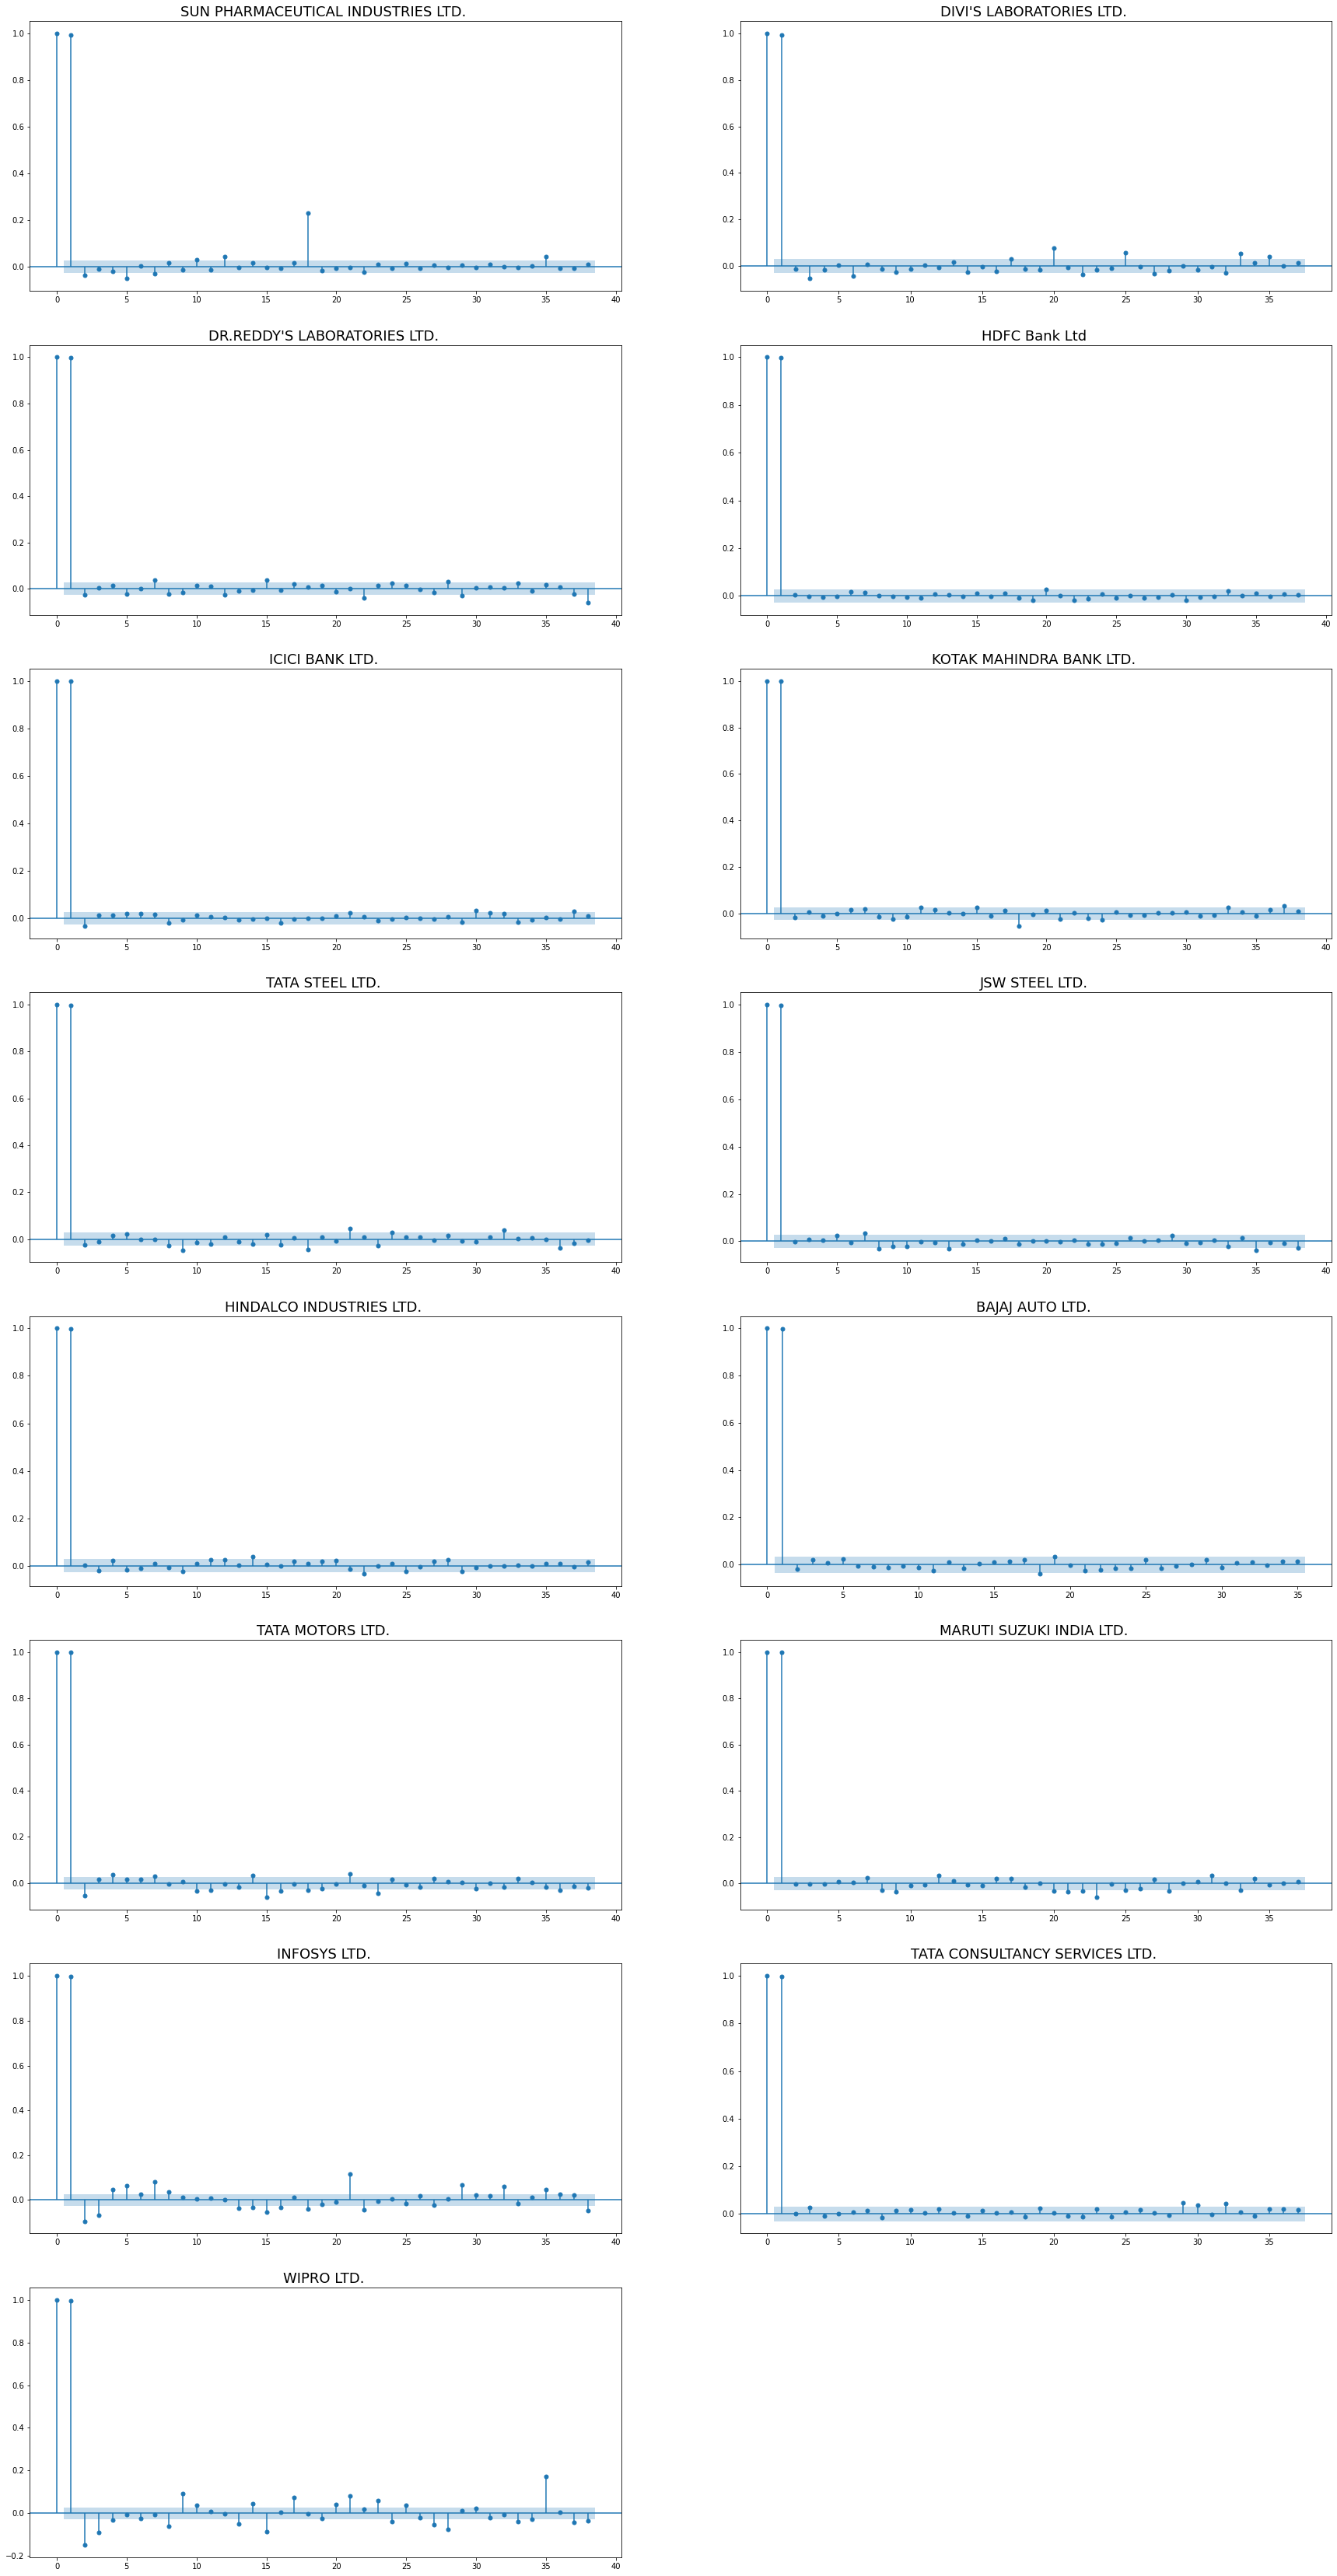

In [46]:
fig = plt.figure(figsize=(30,60))
j = 0
for i in range(15):
    ax1 = fig.add_subplot(8,2,(j+1))
#     ax1.yaxis.set_tick_params(labelsize='large')

    plot_pacf(ScriptWiseData[stocks[i]].Close, ax=ax1);
    ax1.set_title(getStockNameFromStockCode(stocks[i]), fontsize=18)
    j = j + 1

# Save the full figure...
# fig.savefig('./Outputs/PACF4.png')

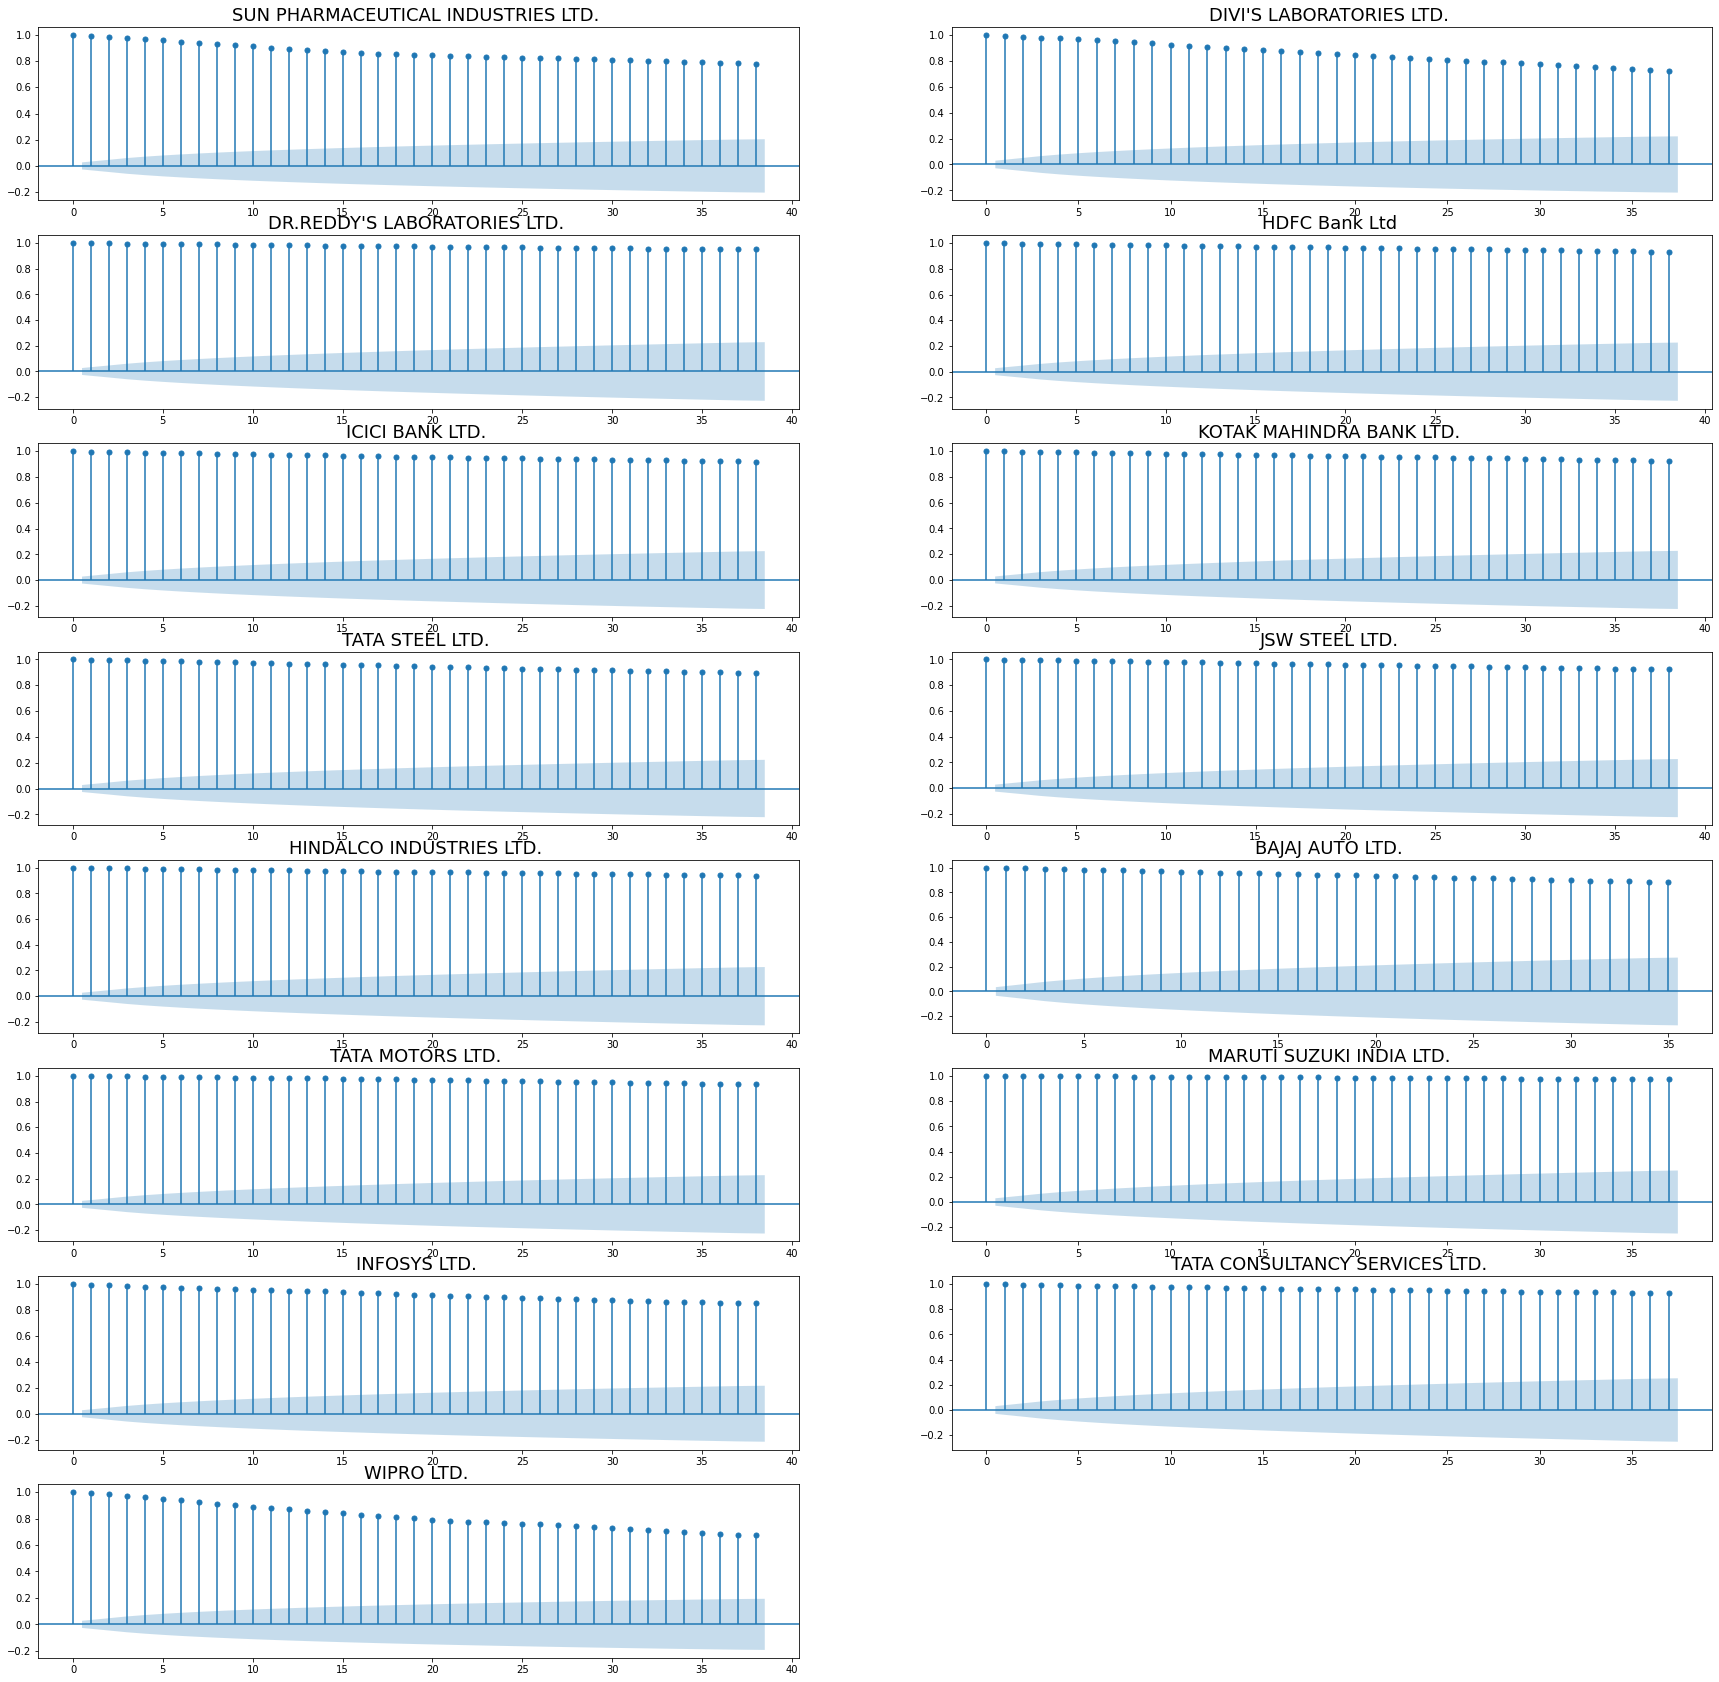

In [47]:
fig = plt.figure(figsize=(30,30))
j = 0
for i in range(15):
    ax1 = fig.add_subplot(8,2,(j+1))
#     ax1.yaxis.set_tick_params(labelsize='large')

    plot_acf(ScriptWiseData[stocks[i]].Close, ax=ax1);
    ax1.set_title(getStockNameFromStockCode(stocks[i]), fontsize=18)
    j = j + 1

# Save the full figure...
# fig.savefig('./Outputs/PACF4.png')

In [48]:
train, test = TrainTestSplitByDateRange(ScriptWiseData[stocks[0]],test_start_date = '2020-03-02',test_end_date = '2021-03-23')

In [49]:
# data = ScriptWiseData[stocks[0]]
# auto_arima(data['Close'], maxiter=1000, seasonality = True, m=12) #seasonality, m parameters pending

In [50]:
# data = ScriptWiseData[stocks[0]]
# auto_arima(data['Close'], maxiter=1000, seasonality = True, m=4) #seasonality, m parameters pending

### AutoARIMA DataFrame


In [51]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [52]:
import pandas as pd

In [53]:
AutoArimaResults = 'AutoArimaResults.csv'
try:
    with open('Outputs/' + AutoArimaResults) as myfile:
        AutoArimaResults = pd.read_csv('Outputs/AutoArimaResults.csv',index_col='Unnamed: 0')  
except IOError as e:
    print('Creating {} file'.format(AutoArimaResults))
    AutoArimaResults = pd.DataFrame(columns=['p Closing Values', 'd Closing Values', 'q Closing Values','p N Closing Values', 'd N Closing Values', 'q N Closing Values','p Closing Percentage', 'd Closing Percentage', 'q Closing Percentage'], index = stocks) 

#AutoArimaResults = pd.DataFrame(columns=['p Closing Values', 'd Closing Values', 'q Closing Values','p N Closing Values', 'd N Closing Values', 'q N Closing Values','p Closing Percentage', 'd Closing Percentage', 'q Closing Percentage'], index = stocks)
#AutoArimaResults = pd.read_csv('Outputs/AutoArimaResults.csv',index_col='Unnamed: 0')


In [54]:
def CalculateAutoArima(stockcode, data, parameter ,p ,d,q):
    if(AutoArimaResults.loc[:, [p, d, q]].isnull().sum(axis=1)[stockcode] > 0):
        params = auto_arima(data[parameter], maxiter = 1000)
        AutoArimaResults.loc[stockcode, [p,d,q]] = params.order
        return params.order
    else:
        return tuple(AutoArimaResults.loc[stockcode, [p, d, q]])

### Common Functions

In [55]:
def errorEvaluation(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared=False)
    MAPE = mean_absolute_percentage_error(actual,pred)
    R2 = r2_score(actual,pred)
    Noise = float(pred.diff().abs().mean())
    return [RMSE, MAPE, R2, Noise]

In [56]:
def modified_prediction_frame(_df_pred, index):
    _df_pred = _df_pred.to_frame()
    _df_pred['Date'] = index
    pd.to_datetime(_df_pred['Date'])
    _df_pred.set_index('Date', inplace=True)
    _df_pred.rename(columns={0 : 'Predicted'}, inplace=True)
    return _df_pred

## ARIMA for Closing Values 

### Generic Function For ARIMA Closing Prices

In [57]:
def ARIMA_Model_Generic(StockCode, data, feature, Results, Order, train_data, test_data):
    print("Modeling for the Stock: {}".format(StockCode))

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1

#     print("ADF Test for the given series.")
#     adf, Stationarity = adf_test(train_data[feature], title=StockCode)
#     print(adf)
#     print('----------------------------------------------------------------------------')
#     Results.loc[StockCode,'Stationarity'] = Stationarity
    model = ARIMA(train_data[feature], order = Order)

    results = model.fit()
#     print(results.params)
#     print("Order: " + str(Order) )
    print('---------------------------------------------------------------------------')
    Results.loc[StockCode, 'Order'] = str(Order)
    Results.loc[StockCode, 'Model'] = model
    Results.loc[StockCode, 'Result'] = results

    predictions = results.predict(start = start, end = end, typ ='levels')
    predictions = modified_prediction_frame(predictions, test_data[feature].index)

    errorEval = errorEvaluation(test_data[feature], predictions)
    RMSE, MAPE, R2, Noise = errorEval
    Results.loc[StockCode, ['RMSE', 'MAPE', 'R2', 'Noise']] = errorEval
    print("RMSE: {0} \nMape: {1} \nR2: {2} \nNoise: {3}".format(RMSE, MAPE, R2, Noise))
    print('---------------------------------------------------------------------------')

#     print('Description of the Predicted Data')
#     print(predictions.describe())
    pred_mean = predictions.mean(numeric_only=True)
    Results.loc[StockCode, 'Predictions Mean'] = str(float(pred_mean))
#     print('---------------------------------------------------------------------------')

#     print('Description of the Actual Data')
#     print(test_data[feature].describe())
    Results.loc[StockCode, 'Actual Mean'] = str(test_data[feature].mean())
    return predictions


In [58]:
try:
    ArimaModelPricesResults = pd.read_csv('./Outputs/ArimaModelPricesResults.csv')
except FileNotFoundError:
    ArimaModelPricesResults = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean', 'Model'], index = stocks)

In [59]:
feature = 'Close'
for stock in stocks:
    try:
        print("Working for Stock - {}".format(stock))
        train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
#         Order = CalculateAutoArima(stock, train_data, feature,  p= 'p Closing Values',d = 'd Closing Values', q = 'q Closing Values')
#         ARIMA_Model_Generic(StockCode = stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults, Order=Order, train_data=train_data, test_data=test_data)
    except:
        pass

Working for Stock - BOM524715
Working for Stock - BOM532488
Working for Stock - BOM500124
Working for Stock - BOM500180
Working for Stock - BOM532174
Working for Stock - BOM500247
Working for Stock - BOM500470
Working for Stock - BOM500228
Working for Stock - BOM500440
Working for Stock - BOM532977
Working for Stock - BOM500570
Working for Stock - BOM532500
Working for Stock - BOM500209
Working for Stock - BOM532540
Working for Stock - BOM507685


In [60]:
# ArimaModelPricesResults.to_csv('./Outputs/ArimaModelPricesResults.csv')

In [61]:
ArimaModelPricesResults

,Unnamed: 0,Unnamed: 0.1,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean,Model,Result
0,0,BOM524715,Stationary,"(0, 1, 1)",212.880495,0.358272,-8.616155,0.356600,321.455060,512.652841,NaN,NaN
1,1,BOM532488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,BOM500124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,BOM500180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,BOM532174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,BOM500247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,BOM500470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,BOM500228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,BOM500440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,BOM532977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ARIMA for Normalized Closing Price

### Normalizing the Values  - Normalized_Prices

In [62]:
normalized_columns = ['Normalized Closing', 'Normalized RSI', 'Normalized ATR', 'Normalized MACD', 'Normalized ADX', 'Normalized OBV']
normalized_TechnicalIndicators = ['Normalized RSI', 'Normalized ATR', 'Normalized MACD', 'Normalized ADX', 'Normalized OBV']

In [63]:
# first value normalization
for stock in stocks:
    cols = list(ScriptWiseData[stock].columns)
    for count in range(len(cols)):
        benchmark_prices = ScriptWiseData[stock][cols[count]].iloc[0]
        ScriptWiseData[stock][normalized_columns[count]] = ScriptWiseData[stock][cols[count]].div(benchmark_prices).mul(100)


###  ARIMA Normalized Closing Prices

In [64]:
try:
    ArimaModelPricesResults_Norm = pd.read_csv('./Outputs/ArimaModelPricesResults_Norm.csv')
except FileNotFoundError:
    ArimaModelPricesResults_Norm = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2','Noise', 'Predictions Mean', 'Actual Mean', 'Model'], index = stocks)

In [65]:
for stock in stocks:
    print("Working for Stock {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    feature = 'Normalized Closing'
#     Order = CalculateAutoArima(stock, train_data, feature,'p N Closing Values', 'd N Closing Values', 'q N Closing Values')
#     ARIMA_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults_Norm, Order=Order, train_data=train_data, test_data=test_data)

Working for Stock BOM524715
Working for Stock BOM532488
Working for Stock BOM500124
Working for Stock BOM500180
Working for Stock BOM532174
Working for Stock BOM500247
Working for Stock BOM500470
Working for Stock BOM500228
Working for Stock BOM500440
Working for Stock BOM532977
Working for Stock BOM500570
Working for Stock BOM532500
Working for Stock BOM500209
Working for Stock BOM532540
Working for Stock BOM507685


In [66]:
# ArimaModelPricesResults_Norm.to_csv('./Outputs/ArimaModelPricesResults_Norm.csv')

## ARIMA Model For Returns

### Convert Closing price to percentage change



> revisit normalization for this section - consider normalizing in range -1 and 1 --- Not done yet



In [67]:
for s in stocks:
    ScriptWiseData[s]['Stock_Returns'] = ScriptWiseData[s]['Close'].pct_change(1).mul(100) 
    ScriptWiseData[s] = ScriptWiseData[s][1:] # Because of NAN first value

In [68]:
stock = stocks[0]
adf_testResult = pd.DataFrame(adf_test(ScriptWiseData[stocks[0]].Stock_Returns, stocks[0])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
for i in range(1, len(stocks)):
    res = pd.DataFrame(adf_test(ScriptWiseData[stocks[i]].Stock_Returns, stocks[i])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
    adf_testResult = adf_testResult.append(res)
adf_testResult['Result'] = adf_testResult['p-value'].apply(lambda x: 'Stationary' if x<0.05 else 'Non-Stationary')
# adf_testResult.to_csv('Outputs/adfTestReturns.csv')
# adf_testResult.to_csv('Outputs/adfTestReturns.csv')
adf_testResult.head()

,,ADF test statistic,p-value,# lags used,#observations,critical value (1%),critical value (5%),critical value (10%),Result
Stock Name,Stock Code,,,,,,,,
SUN PHARMACEUTICAL INDUSTRIES LTD.,BOM524715,-51.489152,0.0,1.0,5251.0,-3.431596,-2.862091,-2.567063,Stationary
DIVI'S LABORATORIES LTD.,BOM532488,-13.923122,0.0,23.0,4432.0,-3.431826,-2.862192,-2.567117,Stationary
DR.REDDY'S LABORATORIES LTD.,BOM500124,-71.618449,0.0,0.0,5253.0,-3.431595,-2.86209,-2.567063,Stationary
HDFC Bank Ltd,BOM500180,-54.580752,0.0,1.0,5252.0,-3.431596,-2.86209,-2.567063,Stationary
ICICI BANK LTD.,BOM532174,-32.126798,0.0,5.0,5247.0,-3.431597,-2.862091,-2.567063,Stationary


### ARIMA for percentage Returns

In [69]:
try:
    ArimaModelPricesResults_Returns = pd.read_csv('./Outputs/ArimaModelPricesResults_Returns.csv')
except FileNotFoundError:
    ArimaModelPricesResults_Returns = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean', 'Model'], index = stocks)

In [70]:
for stock in stocks:
    try:
        print("Working for Stock {}".format(stock))
        train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
        feature = 'Stock_Returns'
#         Order = CalculateAutoArima(stock, train_data, feature, p = 'p Closing Percentage', d = 'd Closing Percentage', q = 'q Closing Percentage')
#         ARIMA_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults_Returns, Order=Order, train_data=train_data, test_data=test_data)
    except Exception as e:
        print(e)

Working for Stock BOM524715
Working for Stock BOM532488
Working for Stock BOM500124
Working for Stock BOM500180
Working for Stock BOM532174
Working for Stock BOM500247
Working for Stock BOM500470
Working for Stock BOM500228
Working for Stock BOM500440
Working for Stock BOM532977
Working for Stock BOM500570
Working for Stock BOM532500
Working for Stock BOM500209
Working for Stock BOM532540
Working for Stock BOM507685


In [71]:
ArimaModelPricesResults_Returns

,Unnamed: 0,Stock Name,RMSE,mape rounded,Adjusted R2,Noise,Predicted Mean,Actual Mean,Unnamed: 8,Actual Mean.1,Model,Result
0,BOM524715,Sun Pharmaceutical Industries Ltd,2.4181,1.016600e+00,-0.0187,0.0006,0.0305,0.2057,NaN,0.205739,<statsmodels.tsa.arima_model.ARMA object at 0x...,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
1,BOM532488,Divi's Laboratories Ltd.,2.3718,1.438800e+00,-0.0191,0.0003,0.1062,0.2202,NaN,0.220249,<statsmodels.tsa.arima_model.ARMA object at 0x...,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
2,BOM500124,Dr. Reddy's Laboratories Ltd.,2.2545,1.032400e+00,-0.0194,0.0000,0.0436,0.1809,NaN,0.180882,<statsmodels.tsa.arima_model.ARMA object at 0x...,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
3,BOM500180,HDFC Bank Ltd,2.6519,1.023100e+00,-0.0191,0.0003,0.0720,0.1257,NaN,0.125669,<statsmodels.tsa.arima_model.ARMA object at 0x...,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
4,BOM532174,ICICI Bank Ltd.,0.0000,0.000000e+00,-0.0194,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
5,BOM500247,Kotak Mahindra Bank Ltd.,2.9141,1.062700e+00,-0.0192,0.0002,0.1039,0.0901,NaN,0.090105,<statsmodels.tsa.arima_model.ARMA object at 0x...,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
6,BOM500470,Tata Steel Ltd.,3.1102,1.010700e+00,-0.0158,0.0035,0.0564,0.3173,NaN,0.317305,<statsmodels.tsa.arima_model.ARMA object at 0x...,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
7,BOM500228,JSW Steel Ltd.,3.1169,1.627800e+00,-0.0194,0.0000,0.5239,0.2888,NaN,0.288780,<statsmodels.tsa.arima_model.ARMA object at 0x...,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
8,BOM500440,Hindalco Industries Ltd.,3.6821,9.859000e-01,-0.0175,0.0018,0.0272,0.3687,NaN,0.368711,<statsmodels.tsa.arima_model.ARMA object at 0x...,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
9,BOM532977,Bajaj Auto Ltd.,2.4343,1.173900e+00,-0.0185,0.0008,0.0861,0.1336,NaN,0.133604,<statsmodels.tsa.arima_model.ARMA object at 0x...,<statsmodels.tsa.arima_model.ARMAResultsWrappe...


In [72]:
# ArimaModelPricesResults_Returns.to_csv('./Outputs/ArimaModelPricesResults_Returns.csv')

In [73]:
# AutoArimaResults.to_csv('Outputs/AutoArimaResults.csv')

### ARIMAX

### Auto ARIMA DataFrame


In [74]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [75]:
try:
    AutoArimaResultsForArimax = pd.read_csv('./Outputs/AutoArimaResultsForArimax.csv')
except FileNotFoundError:
    AutoArimaResultsForArimax = pd.DataFrame(columns=['p Closing Values', 'd Closing Values', 'q Closing Values','p N Closing Values', 'd N Closing Values', 'q N Closing Values','p Closing Percentage', 'd Closing Percentage', 'q Closing Percentage'], index = stocks)

AutoArimaResultsForArimax

,Unnamed: 0,p Closing Values,d Closing Values,q Closing Values,p N Closing Values,d N Closing Values,q N Closing Values,p Closing Percentage,d Closing Percentage,q Closing Percentage
0,BOM524715,0,1,1,0,1,1,1,0,2
1,BOM532488,1,1,3,1,1,3,3,0,1
2,BOM500124,2,1,2,1,1,0,0,0,0
3,BOM500180,0,1,0,0,1,0,1,0,1
4,BOM532174,2,1,1,2,1,1,2,0,4
5,BOM500247,1,1,2,1,1,2,0,0,1
6,BOM500470,2,1,2,2,1,2,2,0,2
7,BOM500228,0,1,0,0,1,0,0,0,0
8,BOM500440,0,1,0,0,1,0,2,0,2
9,BOM532977,1,1,2,1,1,2,0,0,1


In [76]:
def CalculateAutoArimaForArimax(stockcode, data, parameter ,p ,d,q):
    if(AutoArimaResultsForArimax.loc[:, [p, d, q]].isnull().sum(axis=1)[stockcode] > 0):
        params = auto_arima(data[parameter], exog = data[TechnicalIndicators], maxiter = 1000)
        AutoArimaResultsForArimax.loc[stockcode, [p,d,q]] = params.order
        return params.order
    else:
        return tuple(AutoArimaResultsForArimax.loc[stockcode, [p, d, q]])

#### Generic Function for ARIMAX

In [77]:
def ARIMAX_Model_Generic(StockCode, data, feature, Results, Order, train_data, test_data, extra_indicators):
    print("Modeling for the Stock: {}".format(StockCode))

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1

#     print("ADF Test for the given series.")
#     adf, Stationarity = adf_test(train_data[feature], title=StockCode)
#     print(adf)
#     print('----------------------------------------------------------------------------')
#     Results.loc[StockCode,'Stationarity'] = Stationarity

    exog_train = train_data[extra_indicators]
    model = ARIMA(endog = train_data[feature], exog = exog_train , order = Order)
    results = model.fit()
    print(results.params)
    print("Order: " + str(Order) )
    print('---------------------------------------------------------------------------')
    Results.loc[StockCode, 'Order'] = str(Order)

    exog_test = test_data[extra_indicators]
    predictions = results.predict(start = start, end = end, typ ='levels', exog=exog_test)
    predictions = modified_prediction_frame(predictions, test_data[feature].index)

    predictions.plot(figsize=(12,8), legend=True)
    test_data[feature].plot(figsize = (12,8), legend=True)

    errorEval = errorEvaluation(test_data[feature], predictions)
    RMSE, MAPE, R2, Noise = errorEval
    Results.loc[StockCode, ['RMSE', 'MAPE', 'R2', 'Noise']] = errorEval
    Results.loc[StockCode, 'Model'] = model
    Results.loc[StockCode, 'Result'] = results

    print("RMSE: {0} \nMape: {1} \nR2: {2} \nNoise: {3}".format(RMSE, MAPE, R2, Noise))
    print('---------------------------------------------------------------------------')

    print('Description of the Predicted Data')
    print(predictions.describe())
    pred_mean = predictions.mean(numeric_only=True)
    Results.loc[StockCode, 'Predictions Mean'] = str(float(pred_mean))
    print('---------------------------------------------------------------------------')

    print('Description of the Actual Data')
    print(test_data[feature].describe())
    Results.loc[StockCode, 'Actual Mean'] = str(test_data[feature].mean())
    return predictions

## ARIMAX for Closing Prices

In [78]:
try:
    ArimaxModelPricesResults = pd.read_csv('./Outputs/ArimaxModelPricesResults.csv')
except FileNotFoundError:
    ArimaxModelPricesResults = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean', 'Model'], index = stocks)

In [79]:
for stock in stocks:
    print("Working for Stock {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    feature = 'Close'
#     Order = CalculateAutoArimaForArimax(stock, train_data, feature,  p= 'p Closing Values',d = 'd Closing Values', q = 'q Closing Values')
#     ARIMAX_Model_Generic(StockCode = stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults, Order=Order, train_data=train_data, test_data=test_data,extra_indicators = TechnicalIndicators )

Working for Stock BOM524715
Working for Stock BOM532488
Working for Stock BOM500124
Working for Stock BOM500180
Working for Stock BOM532174
Working for Stock BOM500247
Working for Stock BOM500470
Working for Stock BOM500228
Working for Stock BOM500440
Working for Stock BOM532977
Working for Stock BOM500570
Working for Stock BOM532500
Working for Stock BOM500209
Working for Stock BOM532540
Working for Stock BOM507685


### Please check this

In [80]:
# ArimaxModelPricesResults.to_csv('./Outputs/ArimaxModelPricesResults.csv')

In [81]:
ArimaxModelPricesResults

,Unnamed: 0,Stock Name,Adjusted RMSE,Adjusted MAPE,Adjusted R2,Rounded Noise,Noise,Predictions Mean,Actual Mean,Model,Result
0,BOM524715,Sun Pharmaceutical Industries Ltd,317.3846,0.4627,-20.3748,5.0769,5.076907,682.530167,512.652841,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
1,BOM532488,Divi's Laboratories Ltd.,4585.4947,1.2789,-55.9319,28.2324,28.232438,-1090.299098,2955.110795,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
2,BOM500124,Dr. Reddy's Laboratories Ltd.,4271.7530,0.8283,-43.7299,17.9521,17.952109,558.137404,4398.125758,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
3,BOM500180,HDFC Bank Ltd,373.0870,0.2836,-1.6661,5.4074,5.407412,858.010542,1191.321023,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
4,BOM532174,ICICI Bank Ltd.,146.5415,0.2542,-1.0943,4.4142,4.414217,501.701473,431.724053,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
5,BOM500247,Kotak Mahindra Bank Ltd.,378.7946,0.1924,-0.7479,3.2541,3.254100,1440.473051,1528.218750,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
6,BOM500470,Tata Steel Ltd.,119.0272,0.2286,0.4320,3.7808,3.780754,555.059468,452.076326,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
7,BOM500228,JSW Steel Ltd.,408.3543,0.9355,-19.6271,4.1485,4.148483,586.546117,281.715341,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
8,BOM500440,Hindalco Industries Ltd.,199.1102,1.0832,-8.2465,3.4588,3.458808,-0.351375,192.293750,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
9,BOM532977,Bajaj Auto Ltd.,2721.4440,0.7282,-26.5061,18.3689,18.368922,780.529731,3057.258144,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...


## ARIMAX Normalized Closing Prices

In [82]:
try:
    ArimaxModelPricesResults_Norm = pd.read_csv('./Outputs/ArimaxModelPricesResults_Norm.csv')
except FileNotFoundError:
    ArimaxModelPricesResults_Norm = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2','Noise', 'Predictions Mean', 'Actual Mean', 'Model'], index = stocks)


In [83]:
ArimaxModelPricesResults_Norm

,Unnamed: 0,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean,Model,Result
0,BOM524715,Stationary,"(0, 1, 1)",15.880054,0.494424,-23.622305,0.245063,32.776819,23.898785,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
1,BOM532488,Stationary,"(1, 1, 3)",1866.187344,1.355678,-62.891326,11.535535,-511.640878,1135.271147,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
2,BOM500124,Non-Stationary,"(1, 1, 0)",318.985106,0.873856,-48.938924,1.367077,24.449606,310.821608,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
3,BOM500180,Non-Stationary,"(0, 1, 0)",148.640408,0.283588,-1.666059,2.154347,341.836727,474.629890,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
4,BOM532174,Non-Stationary,"(2, 1, 1)",89.958297,0.265637,-1.292939,2.670613,294.995506,253.284865,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
5,BOM500247,Non-Stationary,"(1, 1, 2)",222.664209,0.192424,-0.746449,1.913209,847.203648,898.687886,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
6,BOM500470,Non-Stationary,"(2, 1, 2)",82.320425,0.223410,0.455995,2.831076,390.195290,319.488569,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
7,BOM500228,Non-Stationary,"(0, 1, 0)",7424.625231,0.935453,-19.627062,75.426970,10664.476698,5122.097107,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
8,BOM500440,Non-Stationary,"(0, 1, 0)",23.845538,1.083237,-8.246504,0.414229,-0.042086,23.029192,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
9,BOM532977,Non-Stationary,"(1, 1, 2)",1082.696492,1.299043,-88.299432,7.410341,-237.876999,675.040438,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...


In [84]:
for stock in stocks:
    print("Working for Stock {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    feature = 'Normalized Closing'
#     Order = CalculateAutoArimaForArimax(stock, train_data, feature,'p N Closing Values', 'd N Closing Values', 'q N Closing Values')
#     ARIMAX_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults_Norm, Order=Order, train_data=train_data, test_data=test_data,extra_indicators = normalized_TechnicalIndicators)

Working for Stock BOM524715
Working for Stock BOM532488
Working for Stock BOM500124
Working for Stock BOM500180
Working for Stock BOM532174
Working for Stock BOM500247
Working for Stock BOM500470
Working for Stock BOM500228
Working for Stock BOM500440
Working for Stock BOM532977
Working for Stock BOM500570
Working for Stock BOM532500
Working for Stock BOM500209
Working for Stock BOM532540
Working for Stock BOM507685


In [85]:
# ArimaxModelPricesResults_Norm.to_csv('./Outputs/ArimaxModelPricesResults_Norm.csv')

In [86]:
testLen = pd.DataFrame(columns=['TestLength'], index = stocks)
for s in stocks:
    train, test = TrainTestSplitByDateRange(ScriptWiseData[s])
    testLen.loc[s, 'TestLength'] = len(test)
testLen

,TestLength
BOM524715,265
BOM532488,265
BOM500124,265
BOM500180,265
BOM532174,265
BOM500247,265
BOM500470,265
BOM500228,265
BOM500440,265
BOM532977,265


In [87]:
ArimaxModelPricesResults_Norm

,Unnamed: 0,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean,Model,Result
0,BOM524715,Stationary,"(0, 1, 1)",15.880054,0.494424,-23.622305,0.245063,32.776819,23.898785,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
1,BOM532488,Stationary,"(1, 1, 3)",1866.187344,1.355678,-62.891326,11.535535,-511.640878,1135.271147,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
2,BOM500124,Non-Stationary,"(1, 1, 0)",318.985106,0.873856,-48.938924,1.367077,24.449606,310.821608,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
3,BOM500180,Non-Stationary,"(0, 1, 0)",148.640408,0.283588,-1.666059,2.154347,341.836727,474.629890,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
4,BOM532174,Non-Stationary,"(2, 1, 1)",89.958297,0.265637,-1.292939,2.670613,294.995506,253.284865,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
5,BOM500247,Non-Stationary,"(1, 1, 2)",222.664209,0.192424,-0.746449,1.913209,847.203648,898.687886,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
6,BOM500470,Non-Stationary,"(2, 1, 2)",82.320425,0.223410,0.455995,2.831076,390.195290,319.488569,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
7,BOM500228,Non-Stationary,"(0, 1, 0)",7424.625231,0.935453,-19.627062,75.426970,10664.476698,5122.097107,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
8,BOM500440,Non-Stationary,"(0, 1, 0)",23.845538,1.083237,-8.246504,0.414229,-0.042086,23.029192,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
9,BOM532977,Non-Stationary,"(1, 1, 2)",1082.696492,1.299043,-88.299432,7.410341,-237.876999,675.040438,<statsmodels.tsa.arima_model.ARIMA object at 0...,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...


## ARIMAX Returns

In [88]:
try:
    ArimaxModelPricesResults_Returns = pd.read_csv('./Outputs/ArimaxModelPricesResults_Returns.csv')
except FileNotFoundError:
    ArimaxModelPricesResults_Returns = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean', "Model"], index = stocks)

In [89]:
for stock in stocks:
    try:
        print("Working for Stock {}".format(stock))
        train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
        feature = 'Stock_Returns'
#         Order = CalculateAutoArimaForArimax(stock, train_data, feature, p = 'p Closing Percentage', d = 'd Closing Percentage', q = 'q Closing Percentage')
#         ARIMAX_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults_Returns, Order=Order, train_data=train_data, test_data=test_data, extra_indicators = TechnicalIndicators)
    except Exception as e:
        print(e)  

Working for Stock BOM524715
Working for Stock BOM532488
Working for Stock BOM500124
Working for Stock BOM500180
Working for Stock BOM532174
Working for Stock BOM500247
Working for Stock BOM500470
Working for Stock BOM500228
Working for Stock BOM500440
Working for Stock BOM532977
Working for Stock BOM500570
Working for Stock BOM532500
Working for Stock BOM500209
Working for Stock BOM532540
Working for Stock BOM507685


In [90]:
# ArimaxModelPricesResults_Returns.to_csv('./Outputs/ArimaxModelPricesResults_Returns.csv')

In [91]:
# AutoArimaResultsForArimax.to_csv('./Outputs/AutoArimaResultsForArimax.csv')

## ARIMAX Returns with normalized indicators

In [92]:
try:
    ArimaxModelPricesResults_ReturnsNormalized = pd.read_csv('./Outputs/ArimaxModelPricesResults_Returns.csv')
except FileNotFoundError:
    ArimaxModelPricesResults_ReturnsNormalized = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean', "Model"], index = stocks)

In [93]:
for stock in stocks:
    try:
        print("Working for Stock {}".format(stock))
        train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
        feature = 'Stock_Returns'
        Order = CalculateAutoArimaForArimax(stock, train_data, feature, p = 'p Closing Percentage', d = 'd Closing Percentage', q = 'q Closing Percentage')
        ARIMAX_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults_ReturnsNormalized, Order=Order, train_data=train_data, test_data=test_data, extra_indicators = normalized_TechnicalIndicators)
    except Exception as e:
        print(e)  

Working for Stock BOM524715
'BOM524715'
Working for Stock BOM532488
'BOM532488'
Working for Stock BOM500124
'BOM500124'
Working for Stock BOM500180
'BOM500180'
Working for Stock BOM532174
'BOM532174'
Working for Stock BOM500247
'BOM500247'
Working for Stock BOM500470
'BOM500470'
Working for Stock BOM500228
'BOM500228'
Working for Stock BOM500440
'BOM500440'
Working for Stock BOM532977
'BOM532977'
Working for Stock BOM500570
'BOM500570'
Working for Stock BOM532500
'BOM532500'
Working for Stock BOM500209
'BOM500209'
Working for Stock BOM532540
'BOM532540'
Working for Stock BOM507685
'BOM507685'


In [94]:
# ArimaxModelPricesResults_ReturnsNormalized.to_csv('./Outputs/test.csv')

In [95]:
# ArimaxModelPricesResults_ReturnsNormalized.loc[0, 'Model']

# SARIMA without exogenous

In [157]:
#M to be found using grid search
def SARIMAXProcedureSingle(stockCode, m=12):
    # decompose
    data = ScriptWiseData[stockCode]
    data.index = pd.to_datetime(data.index)
    data=data.asfreq('b')
    data = data.fillna(method='ffill')

    r = auto_arima(data['Close'], maxiter=1000,seasonality = True, m=m)

    train, test = TrainTestSplitByDateRange(data)
    print(len(test))
    model = SARIMAX(train['Close'], order =  r.order, seasonal_order = r.seasonal_order, enforce_invertibility = False)
    results = model.fit()
    predictions = results.predict(start_date, end_date).rename('SARIMA')

    return results, predictions, test, r

In [158]:
SarmaxResultsSingle = pd.DataFrame(columns = ['StockName','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)

In [159]:
sarimaxForecastsSingle = {}
for s in stocks:
    print(getStockNameFromStockCode(s))
    try:
        model, forecasts, test , r = SARIMAXProcedureSingle(s, 4)
        print(f'Model Complete for {getStockNameFromStockCode(s)}')
        sarimaxForecastsSingle[s] = forecasts
        SarmaxResultsSingle.loc[s, ['Model']] =  model
        SarmaxResultsSingle.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        SarmaxResultsSingle.loc[s, ['RMSE']] = mean_squared_error(forecasts, test.Close, squared=False)
        SarmaxResultsSingle.loc[s, ['MAPE']] = mean_absolute_percentage_error(forecasts, test.Close)
        SarmaxResultsSingle.loc[s, ['AdjustedR2']] = r2_score(forecasts, test.Close)
        SarmaxResultsSingle.loc[s, ['Noise']] = forecasts.diff().abs().mean()
        SarmaxResultsSingle.loc[s, ['Order']] = str(r.order)
        SarmaxResultsSingle.loc[s, ['SeasonalOrder']] = str(r.seasonal_order)
        SarmaxResultsSingle.to_csv('./Outputs/SarmaxResultsWithExogenousQuarterly.csv')
        print('Success')
    except:
        print(f"Error Occured {getStockNameFromStockCode(s)}", sys.exc_info())

SarmaxResultsSingle

SUN PHARMACEUTICAL INDUSTRIES LTD. 
277
Model Complete for SUN PHARMACEUTICAL INDUSTRIES LTD. 
Success


,StockName,MAPE,RMSE,AdjustedR2,Noise,Model,Order,SeasonalOrder
BOM524715,SUN PHARMACEUTICAL INDUSTRIES LTD.,0.384905,156.810477,-2708092.594866,0.010578,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(1, 0, 0, 4)"
BOM532488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# SARIMAX yearly 

In [160]:
SarmaxResultsSingleYearly = pd.DataFrame(columns = ['StockName','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)
sarimaxForecastsSingleYearly = {}

In [161]:
sarimaxForecastsSingle = {}
for s in stocks:
    print(getStockNameFromStockCode(s))
    try:
        model, forecasts, test , r = SARIMAXProcedureSingle(s, 12)
        print(f'Model Complete for {getStockNameFromStockCode(s)}')
        sarimaxForecastsSingleYearly[s] = forecasts
        SarmaxResultsSingleYearly.loc[s, ['Model']] =  model
        SarmaxResultsSingleYearly.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        SarmaxResultsSingleYearly.loc[s, ['RMSE']] = mean_squared_error(forecasts, test.Close, squared=False)
        SarmaxResultsSingleYearly.loc[s, ['MAPE']] = mean_absolute_percentage_error(forecasts, test.Close)
        SarmaxResultsSingleYearly.loc[s, ['AdjustedR2']] = r2_score(forecasts, test.Close)
        SarmaxResultsSingleYearly.loc[s, ['Noise']] = forecasts.diff().abs().mean()
        SarmaxResultsSingleYearly.loc[s, ['Order']] = str(r.order)
        SarmaxResultsSingleYearly.loc[s, ['SeasonalOrder']] = str(r.seasonal_order)
        SarmaxResultsSingleYearly.to_csv('./Outputs/SarmaxResultsWithExogenousYearly.csv')
        print('Success')
    except:
        print(f"Error Occured {getStockNameFromStockCode(s)}", sys.exc_info())
SarmaxResultsSingleYearly

SUN PHARMACEUTICAL INDUSTRIES LTD. 
277
Model Complete for SUN PHARMACEUTICAL INDUSTRIES LTD. 
Success


,StockName,MAPE,RMSE,AdjustedR2,Noise,Model,Order,SeasonalOrder
BOM524715,SUN PHARMACEUTICAL INDUSTRIES LTD.,0.375296,154.278063,-836281.314407,0.007578,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 0, 1, 12)"
BOM532488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# SARIMAX With Exogenous MODEL

In [96]:
def SARIMAXProcedure(stockCode, m=4):
    # decompose
    data = ScriptWiseData[stockCode]
    data.index = pd.to_datetime(data.index)
    data=data.asfreq('b')
    data = data.fillna(method='ffill')

    r = auto_arima(data['Close'], exogenous=data[TechnicalIndicators], maxiter=1000,seasonality = True, m=m) #seasonality, m parameters pending

    train, test = TrainTestSplitByDateRange(data)

    model = SARIMAX(train['Close'], exog = train[TechnicalIndicators] ,order =  r.order, seasonal_order = r.seasonal_order, enforce_invertibility = False)
    results = model.fit()
    predictions = results.predict(start_date, end_date, exog=test[TechnicalIndicators]).rename('SARIMA')

    return results, predictions, test, r

In [97]:
import datetime
# try:
#     SarmaxResults = pd.read_csv('./Outputs/SarmaxResults.csv')
# except FileNotFoundError:
SarmaxResults = pd.DataFrame(columns = ['StockName','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)
sarimaxForecasts = {}

In [105]:
for s in stocks:
    print(getStockNameFromStockCode(s))
    try:
#         print(datetime.datetime.now())
        model, forecasts, test , r = SARIMAXProcedure(s)
        print(f'Model Complete for {getStockNameFromStockCode(s)}')
        sarimaxForecasts[s] = forecasts
        SarmaxResults.loc[s, ['Model']] =  model
        SarmaxResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        SarmaxResults.loc[s, ['RMSE']] = mean_squared_error(forecasts, test.Close, squared=False)
        SarmaxResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(forecasts, test.Close)
        SarmaxResults.loc[s, ['AdjustedR2']] = r2_score(forecasts, test.Close)
        SarmaxResults.loc[s, ['Noise']] = forecasts.diff().abs().mean()
        SarmaxResults.loc[s, ['Order']] = str(r.order)
        SarmaxResults.loc[s, ['SeasonalOrder']] = str(r.seasonal_order)
        SarmaxResults.to_csv('./Outputs/SarmaxResultsWithExogenousQuarterly.csv')
        print('Success')
#         print(datetime.datetime.now())
    except:
        print(f"Error Occured {getStockNameFromStockCode(s)}", sys.exc_info())

SUN PHARMACEUTICAL INDUSTRIES LTD. 
2021-07-31 01:36:08.748888
Model Complete for SUN PHARMACEUTICAL INDUSTRIES LTD. 
Success
2021-07-31 01:40:30.060934
DIVI'S LABORATORIES LTD. 
2021-07-31 01:40:30.061928
Model Complete for DIVI'S LABORATORIES LTD. 
Success
2021-07-31 01:43:54.675084
DR.REDDY'S LABORATORIES LTD. 
2021-07-31 01:43:54.675084
Model Complete for DR.REDDY'S LABORATORIES LTD. 
Success
2021-07-31 01:44:37.912889
HDFC Bank Ltd 
2021-07-31 01:44:37.913930
Model Complete for HDFC Bank Ltd 
Success
2021-07-31 01:47:19.143794
ICICI BANK LTD. 
2021-07-31 01:47:19.144838
Model Complete for ICICI BANK LTD. 
Success
2021-07-31 01:54:14.153114
KOTAK MAHINDRA BANK LTD. 
2021-07-31 01:54:14.155112
Model Complete for KOTAK MAHINDRA BANK LTD. 
Success
2021-07-31 02:02:05.621910
TATA STEEL LTD. 
2021-07-31 02:02:05.621910
Model Complete for TATA STEEL LTD. 
Success
2021-07-31 02:02:40.084232
JSW STEEL LTD. 
2021-07-31 02:02:40.085233
Model Complete for JSW STEEL LTD. 
Success
2021-07-31 02

# Sarimax with exogenous yearly

In [139]:
SarmaxResultsExogenousYearly = pd.DataFrame(columns = ['StockName','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)
sarimaxForecastsYearlyExogenous = {}
for s in stocks:
    print(getStockNameFromStockCode(s))
    try:
#         print(datetime.datetime.now())
        model, forecasts, test , r = SARIMAXProcedure(s,12)
        print(f'Model Complete for {getStockNameFromStockCode(s)}')
        sarimaxForecastsYearlyExogenous[s] = forecasts
        SarmaxResultsExogenousYearly.loc[s, ['Model']] =  model
        SarmaxResultsExogenousYearly.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        SarmaxResultsExogenousYearly.loc[s, ['RMSE']] = mean_squared_error(forecasts, test.Close, squared=False)
        SarmaxResultsExogenousYearly.loc[s, ['MAPE']] = mean_absolute_percentage_error(forecasts, test.Close)
        SarmaxResultsExogenousYearly.loc[s, ['AdjustedR2']] = r2_score(forecasts, test.Close)
        SarmaxResultsExogenousYearly.loc[s, ['Noise']] = forecasts.diff().abs().mean()
        SarmaxResultsExogenousYearly.loc[s, ['Order']] = str(r.order)
        SarmaxResultsExogenousYearly.loc[s, ['SeasonalOrder']] = str(r.seasonal_order)
        SarmaxResultsExogenousYearly.to_csv('./Outputs/SarmaxResultsWithExogenousYearly.csv')
        print('Success')
#         print(datetime.datetime.now())
    except:
        print(f"Error Occured {getStockNameFromStockCode(s)}", sys.exc_info())
        
SarmaxResultsExogenousYearly

,Unnamed: 0,StockName,MAE,MAPE,RMSE,AdjustedR2,Noise,Model,Order,SeasonalOrder
0,BOM524715,SUN PHARMACEUTICAL INDUSTRIES LTD.,NaN,0.147088,83.298531,-1.427786,9.901273,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(2, 1, 2)","(0, 0, 2, 4)"
1,BOM532488,DIVI'S LABORATORIES LTD.,NaN,NaN,NaN,NaN,NaN,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,NaN,NaN
2,BOM500124,DR.REDDY'S LABORATORIES LTD.,NaN,NaN,NaN,NaN,NaN,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,NaN,NaN
3,BOM500180,HDFC Bank Ltd,NaN,NaN,NaN,NaN,NaN,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,NaN,NaN
4,BOM532174,ICICI BANK LTD.,NaN,NaN,NaN,NaN,NaN,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,NaN,NaN
5,BOM500247,KOTAK MAHINDRA BANK LTD.,NaN,NaN,NaN,NaN,NaN,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,NaN,NaN
6,BOM500470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BOM500228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,BOM500440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,BOM532977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### VARMAX MODEL

In [106]:
ScriptWiseData[stocks[0]]

,Close,RSI,ATR,MACD,adx,OBV,Normalized Closing,Normalized RSI,Normalized ATR,Normalized MACD,Normalized ADX,Normalized OBV,Stock_Returns
Date,,,,,,,,,,,,,
2000-02-11,2090.00,1.364001,131.2700,97.046900,19.756105,246481.0,97.431355,81.551223,100.582331,92.376124,98.618868,89.602085,-2.568645
2000-02-14,2125.00,1.489559,128.1250,92.209986,19.499189,267854.0,99.062981,89.058167,98.172554,87.772006,97.336389,97.371712,1.674641
2000-02-15,2068.90,1.225341,126.1700,83.260861,18.662103,248155.0,96.447718,73.261033,96.674584,79.253593,93.157809,90.210627,-2.640000
2000-02-16,2075.00,1.246006,125.6700,75.754360,17.763029,256662.0,96.732087,74.496555,96.291472,72.108373,88.669795,93.303136,0.294843
2000-02-17,2240.95,1.848351,130.8625,81.300839,18.112124,296910.0,104.468323,110.509724,100.270094,77.387905,90.412413,107.934304,7.997590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17,585.20,0.682121,17.9600,-1.488529,16.856154,7598758.0,27.280779,40.782849,13.761398,-1.416887,84.142844,2762.340958,-2.798771
2021-03-18,574.50,0.594893,18.3000,-3.999505,18.296442,7374060.0,26.781968,35.567631,14.021914,-3.807013,91.332497,2680.657545,-1.828435
2021-03-19,578.60,0.647393,18.6500,-5.594151,20.001070,7557363.0,26.973101,38.706507,14.290093,-5.324909,99.841688,2747.292827,0.713664


In [107]:
# Train and fit varmax model
def VARMAXProcedure(stockSymbol, column = 'Close'):
    data = ScriptWiseData[stockSymbol]
    data.index = pd.to_datetime(data.index)
    data=data.asfreq('D')
    data = data.fillna(method='ffill')
    data = data[[column]+TechnicalIndicators]
    r = auto_arima(data[column], exogenous=data[TechnicalIndicators], maxiter=1000) #seasonality, m parameters pending
    p, d, q = r.order
    if(p==0 and q==0):
        p = 1
    # make data stationary based on auto arima output
    
    # train test split  
    train, test = TrainTestSplitByDateRange(data)
    
    # fit the model based on above parameters
    model = VARMAX(train, order=(p,q))
    results = model.fit(maxiter=1000, disp=False)
    forecasts = results.forecast(len(test))
    
    #     forecasts = InvertDifferencingForActualResults()
    return results, forecasts, test

In [108]:
import datetime
try:
    VarmaxResults = pd.read_csv('./Outputs/VarmaxResults.csv')
except FileNotFoundError:
    VarmaxResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)
    
for s in stocks:
    print(getStockNameFromStockCode(s))
    try:
        print(datetime.datetime.now())
#         if(np.isnan(VarmaxResults.loc[s, 'MAE'])):
        model, forecasts, test = VARMAXProcedure(s)
        print(f'Model Complete for {getStockNameFromStockCode(s)}')
        VarmaxResults.loc[s, ['Model']] =  model
        VarmaxResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        VarmaxResults.loc[s, ['MAE']] =  mean_absolute_error(forecasts.Close, test.Close)
        VarmaxResults.loc[s, ['RMSE']] = mean_squared_error(forecasts.Close, test.Close, squared=False)
        VarmaxResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(forecasts.Close, test.Close)
        VarmaxResults.loc[s, ['AdjustedR2']] = r2_score(forecasts.Close, test.Close)
        VarmaxResults.loc[s, ['Noise']] = forecasts.Close.diff().abs().mean()
        VarmaxResults.to_csv('./Outputs/VarmaxResults.csv')
        print('Success')
#         else:
#             print('Already exists')
        print(datetime.datetime.now())
    except:
        print(f"Error Occured {getStockNameFromStockCode(s)}", sys.exc_info())

SUN PHARMACEUTICAL INDUSTRIES LTD. 
2021-07-31 02:30:38.997343
Error Occured SUN PHARMACEUTICAL INDUSTRIES LTD.  (<class 'numpy.linalg.LinAlgError'>, LinAlgError('Schur decomposition solver error.'), <traceback object at 0x000001499007FE00>)
DIVI'S LABORATORIES LTD. 
2021-07-31 02:35:50.999515
Error Occured DIVI'S LABORATORIES LTD.  (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001498D88A8C0>)
DR.REDDY'S LABORATORIES LTD. 
2021-07-31 02:46:03.989737
Error Occured DR.REDDY'S LABORATORIES LTD.  (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001499028CD80>)
HDFC Bank Ltd 
2021-07-31 02:46:07.164102
Error Occured HDFC Bank Ltd  (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x00000149B6CA0840>)
ICICI BANK LTD. 
2021-07-31 02:46:07.347103
Error Occured ICICI BANK LTD.  (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001498D901900>)
KOTAK MAHINDRA BANK LTD. 
2021-07-31 02:46:07.

## Varmax for Stock_Returns

In [109]:
ScriptWiseData[stocks[0]].head()

,Close,RSI,ATR,MACD,adx,OBV,Normalized Closing,Normalized RSI,Normalized ATR,Normalized MACD,Normalized ADX,Normalized OBV,Stock_Returns
Date,,,,,,,,,,,,,
2000-02-11,2090.00,1.364001,131.2700,97.046900,19.756105,246481.0,97.431355,81.551223,100.582331,92.376124,98.618868,89.602085,-2.568645
2000-02-14,2125.00,1.489559,128.1250,92.209986,19.499189,267854.0,99.062981,89.058167,98.172554,87.772006,97.336389,97.371712,1.674641
2000-02-15,2068.90,1.225341,126.1700,83.260861,18.662103,248155.0,96.447718,73.261033,96.674584,79.253593,93.157809,90.210627,-2.640000
2000-02-16,2075.00,1.246006,125.6700,75.754360,17.763029,256662.0,96.732087,74.496555,96.291472,72.108373,88.669795,93.303136,0.294843
2000-02-17,2240.95,1.848351,130.8625,81.300839,18.112124,296910.0,104.468323,110.509724,100.270094,77.387905,90.412413,107.934304,7.997590


In [110]:
import datetime
try:
    VarmaxResultsForReturns = pd.read_csv('./Outputs/VarmaxResultsForReturns.csv')
except FileNotFoundError:
    VarmaxResultsForReturns = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)
    
for s in stocks:
    print(getStockNameFromStockCode(s))
    try:
        print(datetime.datetime.now())
        if(np.isnan(VarmaxResultsForReturns.loc[s, 'MAE'])):
            model, forecasts, test = VARMAXProcedure(s, 'Stock_Returns')
            print(f'Model Complete for {getStockNameFromStockCode(s)}')
            VarmaxResultsForReturns.loc[s, ['Model']] =  model
            VarmaxResultsForReturns.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
            VarmaxResultsForReturns.loc[s, ['MAE']] =  mean_absolute_error(forecasts.Close, test.Close)
            VarmaxResultsForReturns.loc[s, ['RMSE']] = mean_squared_error(forecasts.Close, test.Close, squared=False)
            VarmaxResultsForReturns.loc[s, ['MAPE']] = mean_absolute_percentage_error(forecasts.Close, test.Close)
            VarmaxResultsForReturns.loc[s, ['AdjustedR2']] = r2_score(forecasts.Close, test.Close)
            VarmaxResultsForReturns.loc[s, ['Noise']] = forecasts.Close.diff().abs().mean()
            VarmaxResultsForReturns.to_csv('./Outputs/VarmaxResultsForReturns.csv')
            print('Success')
        else:
            print('Already exists')
        print(datetime.datetime.now())
    except:
        print(f"Error Occured {getStockNameFromStockCode(s)}", sys.exc_info())

SUN PHARMACEUTICAL INDUSTRIES LTD. 
2021-07-31 02:46:09.272923
Error Occured SUN PHARMACEUTICAL INDUSTRIES LTD.  (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001498D8331C0>)
DIVI'S LABORATORIES LTD. 
2021-07-31 02:46:09.412962
Error Occured DIVI'S LABORATORIES LTD.  (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x0000014992ADC280>)
DR.REDDY'S LABORATORIES LTD. 
2021-07-31 02:46:09.611926
Error Occured DR.REDDY'S LABORATORIES LTD.  (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x0000014990261080>)
HDFC Bank Ltd 
2021-07-31 02:46:09.780950
Error Occured HDFC Bank Ltd  (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x00000149901B5180>)
ICICI BANK LTD. 
2021-07-31 02:46:10.152415
Error Occured ICICI BANK LTD.  (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x000001498D7C9100>)
KOTAK MAHINDRA BANK LTD. 
2021-07-31 02:46:10.304412
Error Occured KOTAK MAHINDRA 

In [111]:
# VarmaxResultsForReturns

## Prophet models

In [112]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_start_date = pd.to_datetime(start_date)
df_end_date = pd.to_datetime(end_date)

In [113]:
def ProphetProcedure(stockCode, start_date = start_date, end_date = end_date):
    df = ScriptWiseData[stockCode][['Close']]
    df.index = pd.to_datetime(df.index)
    df = df.reset_index()
    
    df.columns = ['ds', 'y']
    
    test_start_date = pd.to_datetime(start_date)
    test_end_date = pd.to_datetime(end_date)
    
    train = df.loc[df.ds<df_start_date]
    test = df.loc[df.ds>=df_start_date]
    m = Prophet()

    m.fit(train)
    future = m.make_future_dataframe(periods = len(test)-1, freq = "B")
#     test_t = test.set_index('ds')
#     future = future.set_index('ds')
#     future = test_t[].join(future).reset_index()
    forecast = m.predict(future)
    
        # initial
    initial = str(5*365)+' days'

    #period
    period = str(365)+' days'

    #horizon
    horizon = str(365) + ' days'
    df_cv = cross_validation(m, initial = initial, period = period, horizon = horizon)
    
    return m, forecast, df_cv

In [114]:
def ProphetProcedureWithExogenousVariables(stockCode, start_date = start_date, end_date = end_date):
    df = ScriptWiseData[stockCode][['Close']+TechnicalIndicators]
    df.index = pd.to_datetime(df.index)
    df = df.reset_index()
    
    df.columns = ['ds', 'y'] + TechnicalIndicators
    
    test_start_date = pd.to_datetime(start_date)
    test_end_date = pd.to_datetime(end_date)
    
    train = df.loc[df.ds<df_start_date]
    test = df.loc[df.ds>=df_start_date]
#     return df, 1
    m = Prophet()
    for t in TechnicalIndicators:
        m.add_regressor(t)
    m.fit(train)
    future = m.make_future_dataframe(periods = len(test)-1, freq = "B")
    test_t = test.set_index('ds')
    future = future.set_index('ds')
    future = test_t[TechnicalIndicators].join(future).reset_index()
    forecast = m.predict(future)
    
        # initial
    initial = str(5*365)+' days'

    #period
    period = str(365)+' days'

    #horizon
    horizon = str(365) + ' days'
    df_cv = cross_validation(m, initial = initial, period = period, horizon = horizon)
    
    return m, forecast, df_cv

In [115]:
# try:
#     ProphetSingleRegressionResults = pd.read_csv('./Outputs/ProphetSingleRegressionResults.csv')
# except FileNotFoundError:
ProphetSingleRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)    

In [116]:
# # initalize result variable
# ProphetForecasts = {}
# for s in stocks:
#     print(s)
#     try:
#         m, forecast, df_cv = ProphetProcedure(s)
#         val_metrics = performance_metrics(df_cv)
#         ProphetSingleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
#         ProphetSingleRegressionResults.loc[s, ['MAE']] =  val_metrics['mae'][0]
#         ProphetSingleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['mse'][0])
#         t = df_cv.dropna()
#         ProphetSingleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat)
#         ProphetSingleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat)
#         ProphetSingleRegressionResults.loc[s, ['Noise']] = t.yhat.diff().abs().mean()
#         ProphetSingleRegressionResults.loc[s, ['Model']] = m
#         ProphetSingleRegressionResults.loc[s, ['Forecast']] = forecast
#         ProphetForecasts[s] = forecast
#         print('Success')
#     except:
#         print("Error Occured", sys.exc_info())
        
# ProphetSingleRegressionResults.to_csv('./Outputs/ProphetSingleRegressionResults.csv')

In [117]:
# # pathProphet, pathProphetMultiple, pathNeuralProphet, pathNeuralProphetMultiple
# for s in stocks:
#     m = ProphetSingleRegressionResults.loc[s, 'Model']
#     forecast = ProphetForecasts[s]
#     title = getStockNameFromStockCode(s)
#     fig = m.plot(forecast,xlabel = 'Date', ylabel= 'Price' )
#     ax = fig.gca()
#     ax.set_title(title, size=16)
    
#     a = add_changepoints_to_plot(fig.gca(), m, forecast)
#     fig.savefig(f'{pathProphet}{title}SingleProphet.png', bbox_inches='tight')
    
#     m.plot_components(forecast).savefig(f'{pathProphet}{title}-Components-SingleProphet.png')

In [118]:
# # try:
# #     ProphetMultipleRegressionResults = pd.read_csv('./Outputs/ProphetMultipleRegressionResults.csv')
# # except FileNotFoundError:
# ProphetMultipleRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)    

In [119]:
# # initalize result variable
# ProphetMultipleRegressionForecasts = {}
# for s in stocks:
#     print(s)
#     try:
#         m, forecast, df_cv = ProphetProcedureWithExogenousVariables(s)
#         val_metrics = performance_metrics(df_cv)
#         ProphetMultipleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
#         ProphetMultipleRegressionResults.loc[s, ['MAE']] =  val_metrics['mae'][0]
#         ProphetMultipleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['mse'][0])
#         t = df_cv.dropna()
#         ProphetMultipleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat)
#         ProphetMultipleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat)
#         ProphetMultipleRegressionResults.loc[s, ['Noise']] = t.yhat.diff().abs().mean()
#         ProphetMultipleRegressionResults.loc[s, ['Model']] = m
#         ProphetMultipleRegressionForecasts[s] = forecast
#         print('Success')
#     except:
#         print("Error Occured", sys.exc_info())
        
# ProphetMultipleRegressionResults.to_csv('./Outputs/ProphetMultipleRegressionResults.csv')

## Plot Prophet results for multiple Regression

In [120]:
# # pathProphet, pathProphetMultiple, pathNeuralProphet, pathNeuralProphetMultiple
# for s in stocks:
#     m = ProphetMultipleRegressionResults.loc[s, 'Model']
#     forecast = ProphetMultipleRegressionForecasts[s]
#     title = getStockNameFromStockCode(s)
#     fig = m.plot(forecast,xlabel = 'Date', ylabel= 'Price' )
#     ax = fig.gca()
#     ax.set_title(title, size=16)
    
#     a = add_changepoints_to_plot(fig.gca(), m, forecast)
#     fig.savefig(f'{pathProphetMultiple}{title}-MultipleProphet.png', bbox_inches='tight')
    
#     ap = m.plot_components(forecast)
# #     ax1 = ap.gca()
# #     ax1.set_title(title, size=16)
#     ap.savefig(f'{pathProphetMultiple}{title}-Components-MultipleProphet.png')

In [121]:
# results = performance_metrics(df_cv)
# results.head(2)

In [122]:
# m.plot_components(forecast);

In [123]:
# ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

# df.plot(x='ds',y='y',label='Actual Price',legend=True,ax=ax) #,xlim=(df_start_date,df_end_date))

In [124]:
# plot_cross_validation_metric(df_cv, metric='rmse');

## Neural Prophet and AR-Net

In [125]:
# from neuralprophet import NeuralProphet, set_random_seed , set_log_level
# set_random_seed(0)
# set_log_level("ERROR")

In [126]:
# df = ScriptWiseData['BOM500180'].reset_index()
# df = df[['Date', 'Close']]
# df.columns = ['ds', 'y']
# df.head()

### Basic Model

In [127]:
# NeuralProphetSingleForecast= {}
# NeuralProphetMultipleForecast= {}

In [128]:
# def BuildNeuralProphetModels(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5, columnName = 'Close'):
#     # prepare the dataset
#     df = dataset.reset_index()
#     df = df[['Date', columnName]]
#     df.columns = ['ds', 'y']
    
#     # train test splilt
#     train = df.loc[(df['ds'] < start_date)]
#     df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
#     # initalize the model
#     m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
    
#     # split the training set into train and validation set
#     df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

#     # fit and test the model
#     train_metrics = m.fit(df_train, freq='D', progress_bar = False)
#     val_metrics = m.test(df_val)
    
#     # make forecasts
#     future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
# #     future = m.make_future_dataframe(df_test, n_historic_predictions= True)
#     forecast = m.predict(future)
#     return (m, forecast,  train_metrics, val_metrics)

In [129]:
# try:
#     NPSingleRegressionResults = pd.read_csv('./Outputs/NeuralProphetSingleRegressionResults.csv')
# except FileNotFoundError:
NPSingleRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)

In [130]:
# # initalize result variable
# for s in stocks:
#     print(s)
#     try:
#         m, forecast , train_metrics, val_metrics = BuildNeuralProphetModels(ScriptWiseData[s])
#         NPSingleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
#         NPSingleRegressionResults.loc[s, ['MAE']] =  val_metrics['MAE'][0]
#         NPSingleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['MSE'][0])
#         t = forecast.dropna()
#         NPSingleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat1)
#         NPSingleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat1)
#         NPSingleRegressionResults.loc[s, ['Noise']] = t.yhat1.diff().abs().mean()
#         NPSingleRegressionResults.loc[s, ['Model']] = m
#         NeuralProphetSingleForecast[s] = forecast
#         print('Success')
#     except Exception as ex:
#         print("Error Occured", ex)
        
# NPSingleRegressionResults.to_csv('./Outputs/NeuralProphetSingleRegressionResults.csv')

In [131]:
# # NPSingleRegressionResults
# # pathProphet, pathProphetMultiple, pathNeuralProphet, pathNeuralProphetMultiple
# for s in stocks:
#     try:
#         m = NPSingleRegressionResults.loc[s, 'Model']
#         forecast = NeuralProphetSingleForecast[s]
#         title = getStockNameFromStockCode(s)
#         fig = m.plot(forecast,xlabel = 'Date', ylabel= 'Price' )
#         ax = fig.gca()
#         ax.set_title(title, size=16)

#         fig.savefig(f'{pathNeuralProphet}{title}-NeuralProphet.png', bbox_inches='tight')

#         ap = m.plot_components(forecast)
#         ap.savefig(f'{pathNeuralProphet}{title}-Components-NeuralProphet.png')

#         fig_param = m.plot_parameters()
#         fig_param.savefig(f'{pathNeuralProphet}{title}-Params-NeuralProphet.png')
#     except:
#         pass
# #     print(type(fig_param), type(ap), type(fig))

## Multiple regressors

In [132]:
# def BuildNeuralProphetModelsWithMultipleRegressors(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5):
#     # prepare the dataset
#     df = dataset.reset_index()
#     df = df[['Date', 'Close']+TechnicalIndicators]
#     df.columns = ['ds', 'y', 'A', 'B', 'C', 'D', 'E']
    
#     # train test splilt
#     train = df.loc[(df['ds'] < start_date)]
#     df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
#     # initalize the model
#     m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
#     # lagged regressors
#     m.add_lagged_regressor(name='A')
#     m.add_lagged_regressor(name='B')
#     m.add_lagged_regressor(name='C')
#     m.add_lagged_regressor(name='D')
#     m.add_lagged_regressor(name='E')
    
#     # split the training set into train and validation set
#     df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

#     # fit and test the model
#     train_metrics = m.fit(df_train, freq='D',progress_bar = False)
#     val_metrics = m.test(df_val)
    
#     # make forecasts
#     # future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
#     future = m.make_future_dataframe(df_test, n_historic_predictions= True)
#     forecast = m.predict(future)
#     return (m, forecast,  train_metrics, val_metrics)

In [133]:
# try:
#     NPExogenousRegressionResults = pd.read_csv('./Outputs/NeuralProphetRegressionWithExogenousVariablesResults.csv')
# except FileNotFoundError:
NPExogenousRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise', 'Model'], index = stocks)

In [134]:
# # initalize result variable
# NPExogenousRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)
# for s in stocks:
#     print(s)
#     try:
#         m, forecast , train_metrics, val_metrics = BuildNeuralProphetModelsWithMultipleRegressors(ScriptWiseData[s])
#         NPExogenousRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
#         NPExogenousRegressionResults.loc[s, ['MAE']] =  val_metrics['MAE'][0]
#         NPExogenousRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['MSE'][0])
#         t = forecast.dropna()
#         NPExogenousRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat1)
#         NPExogenousRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat1)
#         NPExogenousRegressionResults.loc[s, ['Noise']] = t.yhat1.diff().abs().mean()
#         NPExogenousRegressionResults.loc[s, ['Model']] = m
#         NeuralProphetMultipleForecast[s]  = forecast
#         print('Success')
#     except:
#         print("Error Occured")
        
# NPExogenousRegressionResults.to_csv('./Outputs/NeuralProphetRegressionWithExogenousVariablesResults.csv')

In [135]:
# # NPSingleRegressionResults
# # pathProphet, pathProphetMultiple, pathNeuralProphet, pathNeuralProphetMultiple
# for s in stocks:
#     try:
#         m = NPExogenousRegressionResults.loc[s, 'Model']
#         forecast = NeuralProphetMultipleForecast[s]
#         title = getStockNameFromStockCode(s)
#         fig = m.plot(forecast,xlabel = 'Date', ylabel= 'Price' )
#         ax = fig.gca()
#         ax.set_title(title, size=16)

#         fig.savefig(f'{pathNeuralProphetMultiple}{title}-NeuralProphetMultiple.png', bbox_inches='tight')

#         ap = m.plot_components(forecast)
#         ap.savefig(f'{pathNeuralProphetMultiple}{title}-Components-NeuralProphetMultiple.png',bbox_inches='tight')

#         fig_param = m.plot_parameters()
#         fig_param.savefig(f'{pathNeuralProphetMultiple}{title}-Params-NeuralProphetMultiple.png', bbox_inches='tight')
#     except:
#         pass

In [136]:
# train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [False, False]).head(3)

In [137]:
# train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [True, True]).head(3)

In [138]:
# val_metrics